In [21]:
!pip install pillow exifread folium numpy

In [23]:
from google.colab import files
from PIL import Image
import exifread
import numpy as np
import folium


In [47]:
uploaded = files.upload()


Saving IMG_9707.jpg to IMG_9707.jpg


Text(0.5, 1.0, 'Original Photo (Human Framing)')

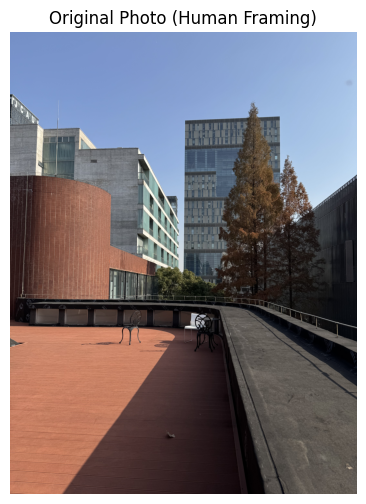

In [61]:
import matplotlib.pyplot as plt

img = Image.open(image_path)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Original Photo (Human Framing)")


In [49]:
image_path = list(uploaded.keys())[0]
print("Using image:", image_path)


Using image: IMG_9707.jpg


In [50]:
def extract_gps(image_path):
    with open(image_path, 'rb') as f:
        tags = exifread.process_file(f, details=False)

    if 'GPS GPSLatitude' not in tags:
        print("No GPS data found.")
        return None, None

    def to_decimal(coord):
        d = coord.values[0].num / coord.values[0].den
        m = coord.values[1].num / coord.values[1].den
        s = coord.values[2].num / coord.values[2].den
        return d + (m / 60) + (s / 3600)

    lat = to_decimal(tags['GPS GPSLatitude'])
    lon = to_decimal(tags['GPS GPSLongitude'])

    if tags['GPS GPSLatitudeRef'].values != 'N':
        lat = -lat
    if tags['GPS GPSLongitudeRef'].values != 'E':
        lon = -lon

    return lat, lon


In [51]:
latitude, longitude = extract_gps(image_path)
latitude, longitude


(31.287158333333334, 121.50047222222223)

In [52]:
def image_brightness(image_path):
    img = Image.open(image_path).convert('L')
    arr = np.array(img)
    return arr.mean()


In [53]:
brightness = image_brightness(image_path)
brightness


np.float64(103.9657571361878)

In [54]:
def image_luminance(image_path):
    img = Image.open(image_path).convert('RGB')
    arr = np.array(img)

    r, g, b = arr[:,:,0], arr[:,:,1], arr[:,:,2]
    luminance = 0.2126*r + 0.7152*g + 0.0722*b
    return luminance.mean()


In [55]:
luminance = image_luminance(image_path)
luminance


np.float64(103.06701478913457)

In [56]:
sound_note = input("Describe the sound environment: ")
smell_note = input("Describe the smell: ")
body_note = input("Describe bodily sensation: ")


Describe the sound environment: quiet
Describe the smell: fruity
Describe bodily sensation: hot


In [57]:
!pip install torch torchvision opencv-python


In [58]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas.eval()

transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = transforms.small_transform


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [59]:
def real_depth_map(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    input_batch = transform(img)   #! no unsqueeze

    with torch.no_grad():
        prediction = midas(input_batch)

    depth = prediction.squeeze().cpu().numpy()
    depth = (depth - depth.min()) / (depth.max() - depth.min())
    return depth


(np.float64(-0.5), np.float64(191.5), np.float64(255.5), np.float64(-0.5))

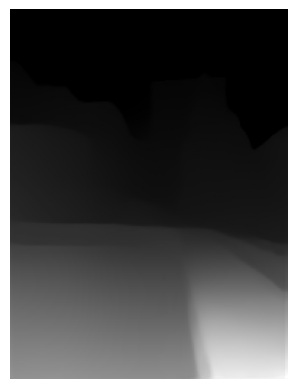

In [60]:
depth = real_depth_map(image_path)
plt.imshow(depth, cmap="gray")
plt.axis("off")
